In [1]:
%matplotlib notebook

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from pathlib import Path
from natsort import natsorted
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from scipy import stats
from scipy.signal import savgol_filter
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# to import package in parent folder first add the parent folder to path
import sys
import os
packages_path = Path(os.path.dirname(os.path.realpath('__file__'))).parent
sys.path.insert(0, str(packages_path))

import shared_func

In [3]:
home_path = os.getcwd()

filepath = Path(home_path, 'Fig6_data')
savepath = Path(home_path, 'plots')
stat_savepath = Path(home_path, 'stats')

Path(savepath).mkdir(parents=True, exist_ok=True) 
Path(stat_savepath).mkdir(parents=True, exist_ok=True) 

# Hyperscope data (larva) comes with 30 Hz image aquisition frequency
aq_rate = 30

In [4]:
scatterplot_ylim_min=-1
scatterplot_ylim_max= 10

In [5]:
filename = 'Fig6_CDE'
# read the numpy array
data = np.load(Path(filepath, filename + '.npy'))
# and also read the metadata to have everything in one place
with open(Path(filepath, filename + '.txt')) as f:
    metadata = f.read()
    print(metadata)

This numpy array contains the data to create Figure 4C, D and E. 
These plots show that decreasing light intensity from 73uW/mm2 
down to 8uW/mm2 helps with the interpretation of calcium imaging data.
The stimulus duration is 1 second and the stimulus wavelength 590nm. 

Output data is organized the following way:

1st dimension is 600. These are the datapoints 

2nd dimension is 7. These are: Time, Stim, df/f1, df/f2, df/f3, df/f4, df/f5. 
Each df/f is a repeat on the same animal 

3rd dimension is 5, one for each animal 

4th dimension is 3. These are: 8uW/mm2, 47uW/mm2 and 72uW/mm2 

5th dimension is 3. The first contains Gal4+, ATR- data, the second contains Gal4+, ATR+ data
the third contains Gal4-, ATR+

As and example, if one wants to grab Gal4+, ATR+, 8uW/mm2 data the indeces are: 
data[:, 2::,:,0,1].



# 73 uW/mm2

<IPython.core.display.Javascript object>


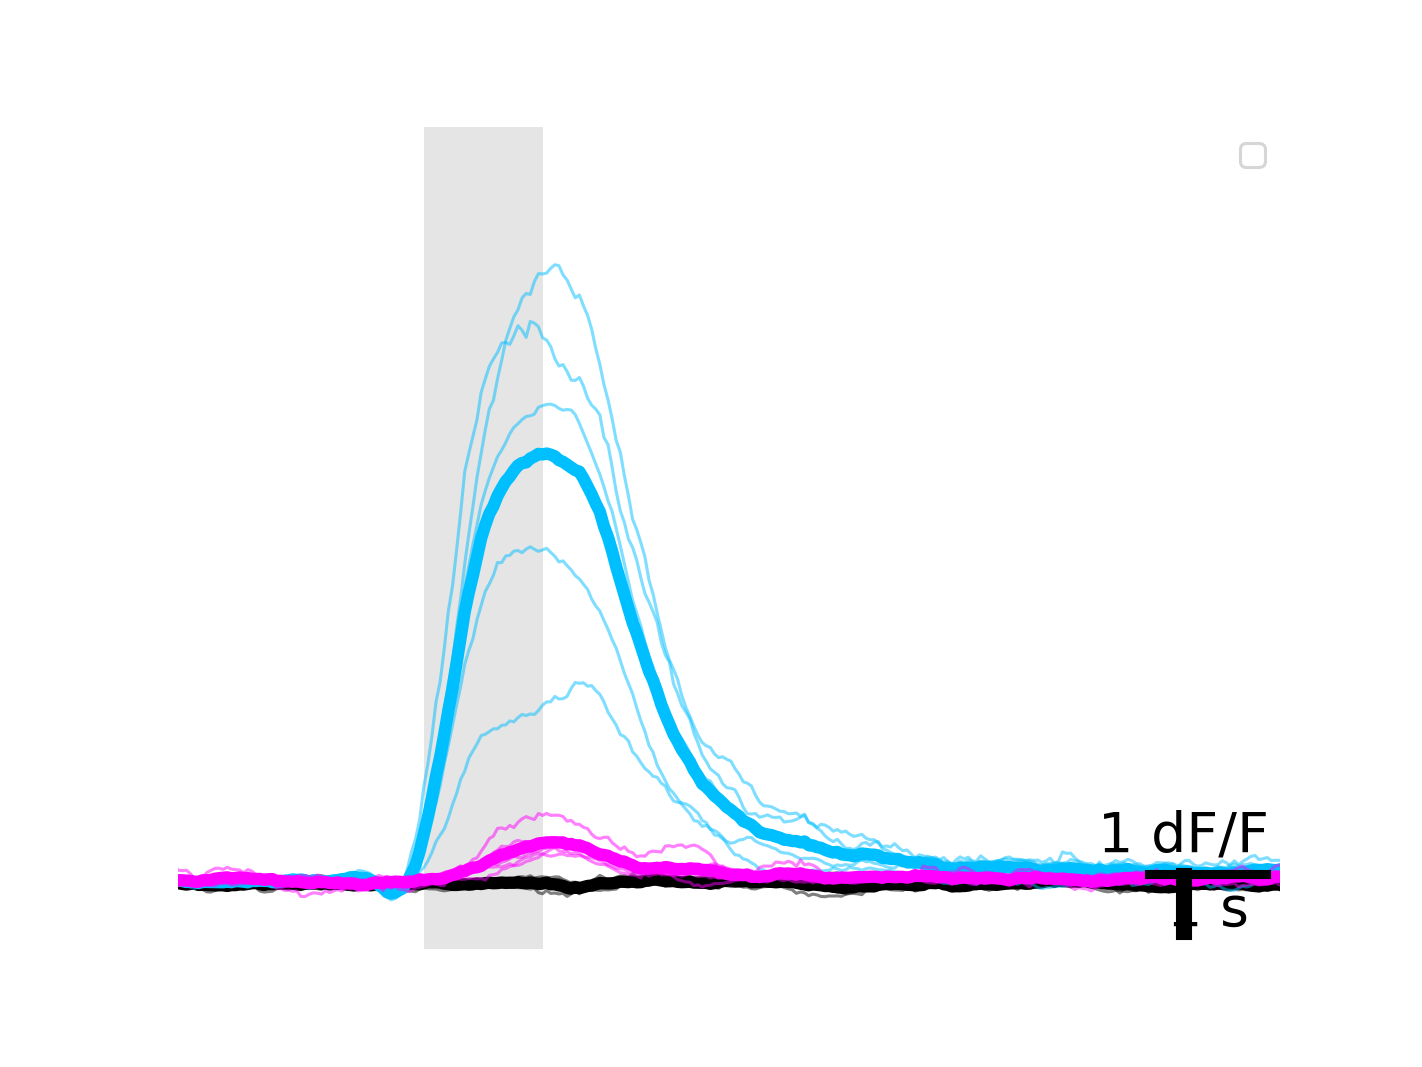

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [6]:
# Define colors used for this plot

colors = ['k',
          'deepskyblue',
          'magenta',
        ]

# Prepare the raw data for plotting
median_per_animal = shared_func.median_per_animal_func(aq_rate=aq_rate, data=data)

# Then, plot the trace plot
fig = plt.figure()
ax = fig.add_subplot(111)

# First, plot light intensity 72uW/mmw 
stim_intensity = 2

for group in range(3):

    ax.plot(data[:,0,0,stim_intensity, group], median_per_animal[:,:,stim_intensity, group], 
            lw=1, zorder=1, color=colors[group], alpha=0.5)
    # and plot the mean of the median in bold
    ax.plot(data[:,0,0,stim_intensity, group], 
            np.mean(median_per_animal[:,:,stim_intensity, group], axis=1), 
            lw=4, zorder=1, color=colors[group])

# Plot stimulus
start_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][0]
stop_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][-1]
ax.axvspan(data[start_stim, 0, 0, stim_intensity, 0],
           data[stop_stim, 0, 0, stim_intensity, 0],
           lw=0, zorder=0,
           color='k',
           alpha=0.1)
ax.set_xlim(1, 10)

fontprops = fm.FontProperties(size=18)
scalebar_time = AnchoredSizeBar(ax.transData,
                                1, '1 s', 'lower right',
                                pad=0.1,
                                color='black',
                                frameon=False,
                                size_vertical=0.1,
                                fontproperties=fontprops)

scalebar_df = AnchoredSizeBar(ax.transData,
                              0.1, '1 dF/F', 'lower right',
                              pad=0.1,
                              color='black',
                              frameon=False,
                              size_vertical=1,
                              fontproperties=fontprops,
                              label_top=True)

ax.add_artist(scalebar_time)
ax.add_artist(scalebar_df)
ax.legend()
ax.axis('off')
ax.set_ylim(-1,11)

savename = 'Fig6D_73uW.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

In [7]:
# Median values before and during
# For readability explicitly state what is being taken
before_start_index = int(round(start_stim-aq_rate*1)) # one second before start
before_end_index = start_stim

during_start_index = int(round(stop_stim-aq_rate*0.5)) # take half second before the end of the stimulus...
during_end_index = int(round(stop_stim+aq_rate*0.5)) # ...until half second after the end of the stimulus

median_before_stim = np.median(median_per_animal[before_start_index:start_stim, :, :],axis=0)
median_during_stim = np.median(median_per_animal[during_start_index:during_end_index, :, :],axis=0)

<IPython.core.display.Javascript object>


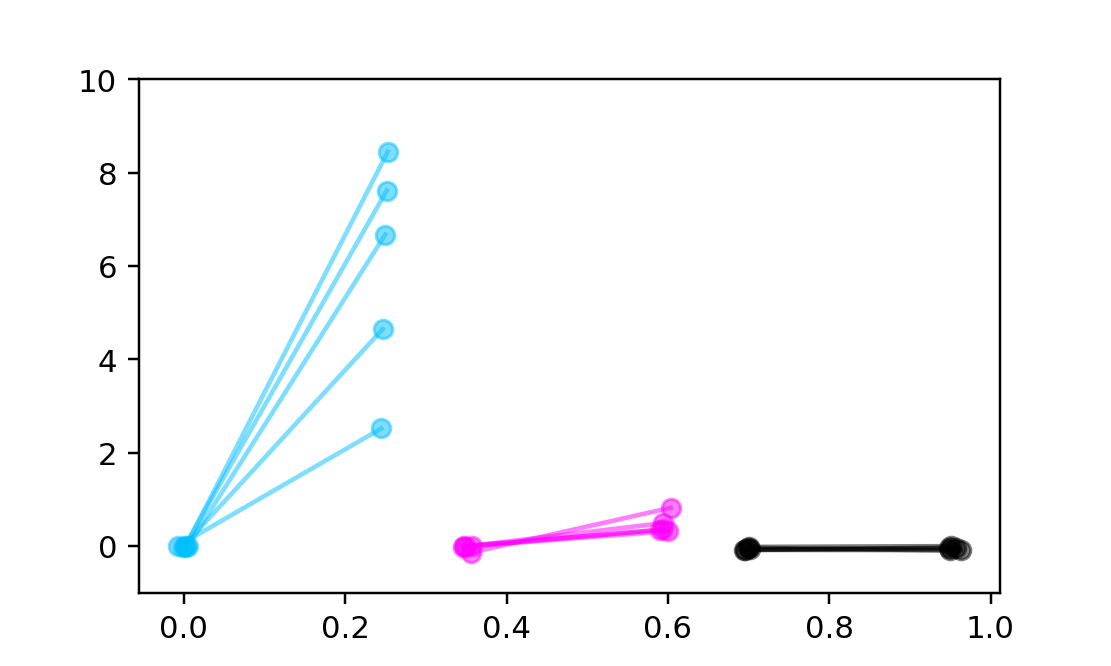

In [8]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)

stim_intensity = 2 # 72 uW/mm2
# First plot Gal4+, ATR+
shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[1], start_x_position=0, group=1)
# Then Gal4-, ATR+
shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[2], start_x_position=0.35, group=2)
# Finally Gal4+, ATR-
shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[0], start_x_position=0.7, group=0)

ax.set_ylim(-1,10)
savename = 'Fig6E_73uW.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

In [9]:
p_values=[]


stim_intensity = 2 # 72 uW/mm2

# median_before_stim_ATR.shape
# (5, 3, 3) # Animal, light intensity, group
print('Gal4+, ATR+')
shared_func.pairwise_t_tests(median_during_stim[:,stim_intensity,1], 
                             median_before_stim[:,stim_intensity,1], p_values) # Gal4+, ATR+

print('Gal4-, ATR+')
shared_func.pairwise_t_tests(median_during_stim[:,stim_intensity,2], 
                             median_before_stim[:,stim_intensity,2], p_values) # Gal4-, ATR+
print('Gal4+, ATR-')
shared_func.pairwise_t_tests(median_during_stim[:,stim_intensity,0], 
                             median_before_stim[:,stim_intensity,0], p_values) # Gal4+, ATR-

print('Holms-Bonferroni correction:')
shared_func.holms_bonferroni_correction(p_values)

Gal4+, ATR+
lilliefors: 0.6658503164499091
T-Test
TtestResult(statistic=5.5792736306309205, pvalue=0.005059600021981532, df=4)


Gal4-, ATR+
lilliefors: 0.10686939584068306
T-Test
TtestResult(statistic=4.233532104889484, pvalue=0.013332319222629941, df=4)


Gal4+, ATR-
lilliefors: 0.796402750184987
T-Test
TtestResult(statistic=0.37570045373702476, pvalue=0.7262148362075673, df=4)


Holms-Bonferroni correction:
significantly different with:
current p: 0.005059600021981532, current alpha: 0.016666666666666666
significantly different with:
current p: 0.013332319222629941, current alpha: 0.025
NOT DIFFERENT!
current p: 0.7262148362075673, current alpha: 0.05


### Export stats

In [10]:
stim_intensity = 2 # 72 uW/mm2

data_export = [[median_during_stim[:,stim_intensity,1], median_before_stim[:,stim_intensity,1]],
               [median_during_stim[:,stim_intensity,2], median_before_stim[:,stim_intensity,2]],
               [median_during_stim[:,stim_intensity,0], median_before_stim[:,stim_intensity,0]]
       ]

label_list_stat_export = [['During, Gal4+, ATR+', 'Before, Gal4+, ATR+'],
                          ['During, Gal4-, ATR+', 'Before, Gal4-, ATR+'],
                          ['During, Gal4+, ATR-', 'Before, Gal4+, ATR-']]
savename = 'Fig_6E_73uW'

shared_func.export_pairwise_dependent_test(data_export, label_list_stat_export,
                                           savepath=stat_savepath, savename=savename,
                                           parametric=True)

                 Group  n      mean    median       STD       SEM  \
0  During, Gal4+, ATR+  5  5.980631  6.671894  2.145334  0.959422   
1  Before, Gal4+, ATR+  5 -0.004086 -0.000334  0.007940  0.003551   
2  During, Gal4-, ATR+  5  0.465307  0.356175  0.186096  0.083224   
3  Before, Gal4-, ATR+  5 -0.034733 -0.012994  0.054160  0.024221   
4  During, Gal4+, ATR-  5 -0.054099 -0.050545  0.033883  0.015153   
5  Before, Gal4+, ATR-  5 -0.060763 -0.073815  0.026185  0.011710   

                               95% CI on the mean  DOF statistical test  \
0           (3.002430659829311, 8.95883207623026)  4.0       T-test rel   
1  (-0.015108233790185447, 0.0069370433472111664)  NaN              NaN   
2        (0.2069646910528558, 0.7236488240988641)  4.0       T-test rel   
3     (-0.10992018563455656, 0.04045341867194675)  NaN              NaN   
4   (-0.10113618878530412, -0.007061976598839247)  4.0       T-test rel   
5    (-0.09711458368697148, -0.02441216856104745)  NaN            

# 47 uW/mm2

<IPython.core.display.Javascript object>


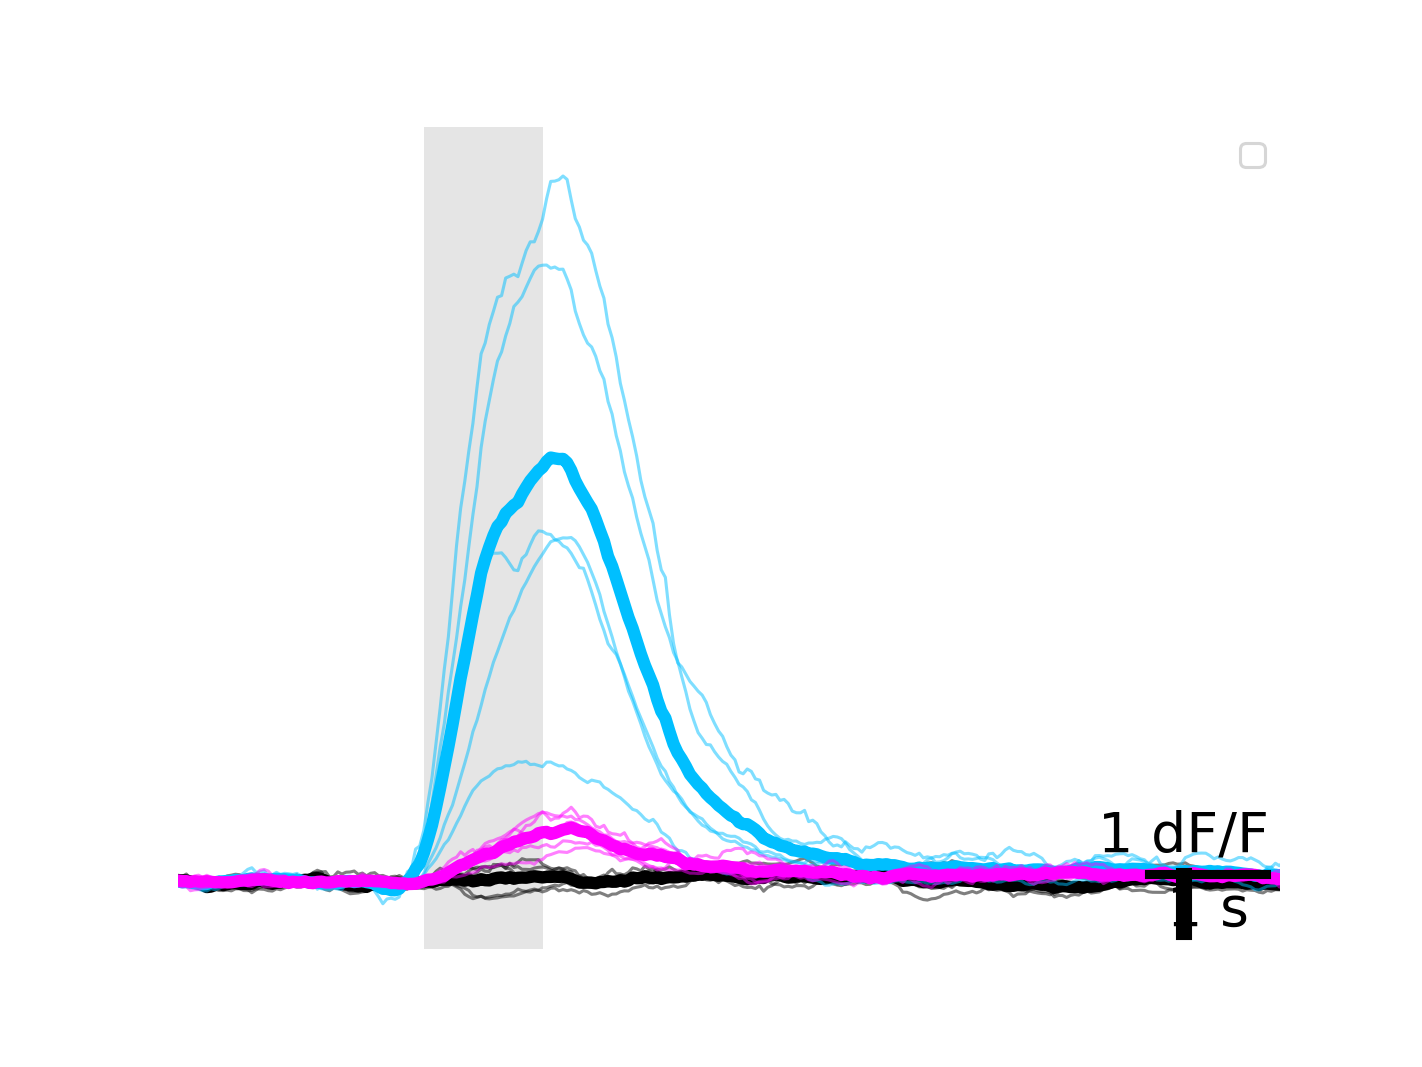

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [11]:
# Then, plot the trace plot
fig = plt.figure()
ax = fig.add_subplot(111)

# First, plot light intensity 47uW/mmw 
stim_intensity = 1

for group in range(3):

    ax.plot(data[:,0,0,stim_intensity, group], median_per_animal[:,:,stim_intensity, group], 
            lw=1, zorder=1, color=colors[group], alpha=0.5)
    # and plot the mean of the median in bold
    ax.plot(data[:,0,0,stim_intensity, group], 
            np.mean(median_per_animal[:,:,stim_intensity, group], axis=1), 
            lw=4, zorder=1, color=colors[group])

# Plot stimulus
start_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][0]
stop_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][-1]
ax.axvspan(data[start_stim, 0, 0, stim_intensity, 0],
           data[stop_stim, 0, 0, stim_intensity, 0],
           lw=0, zorder=0,
           color='k',
           alpha=0.1)
ax.set_xlim(1, 10)

fontprops = fm.FontProperties(size=18)
scalebar_time = AnchoredSizeBar(ax.transData,
                                1, '1 s', 'lower right',
                                pad=0.1,
                                color='black',
                                frameon=False,
                                size_vertical=0.1,
                                fontproperties=fontprops)

scalebar_df = AnchoredSizeBar(ax.transData,
                              0.1, '1 dF/F', 'lower right',
                              pad=0.1,
                              color='black',
                              frameon=False,
                              size_vertical=1,
                              fontproperties=fontprops,
                              label_top=True)

ax.add_artist(scalebar_time)
ax.add_artist(scalebar_df)
ax.legend()
ax.axis('off')
ax.set_ylim(-1,11)

savename = 'Fig6D_47uW.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

<IPython.core.display.Javascript object>


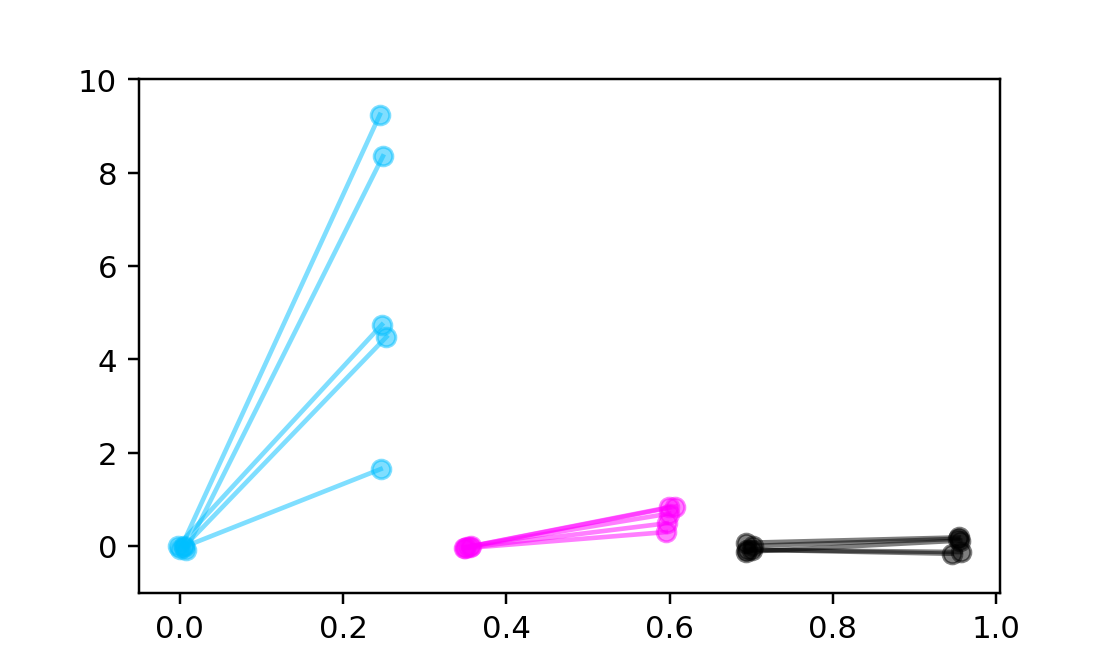

In [12]:
fig = plt.figure(figsize=(5,3))

ax = fig.add_subplot(111)

stim_intensity = 1 # 47 uW/mm2
# First plot Gal4+, ATR+
shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[1], start_x_position=0, group=1)
# Then Gal4-, ATR+
shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[2], start_x_position=0.35, group=2)
# Finally Gal4+, ATR-
shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[0], start_x_position=0.7, group=0)

ax.set_ylim(-1,10)
savename = 'Fig6E_47uW.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

In [13]:
p_values=[]

stim_intensity = 1 # 47 uW/mm2

# median_before_stim_ATR.shape
# (5, 3, 3) # Animal, light intensity, group
print('Gal4+, ATR+')
shared_func.pairwise_t_tests(median_during_stim[:,stim_intensity,1], 
                             median_before_stim[:,stim_intensity,1], p_values) # Gal4+, ATR+

print('Gal4-, ATR+')
shared_func.pairwise_t_tests(median_during_stim[:,stim_intensity,2], 
                             median_before_stim[:,stim_intensity,2], p_values) # Gal4-, ATR+
print('Gal4+, ATR-')
shared_func.pairwise_t_tests(median_during_stim[:,stim_intensity,0], 
                             median_before_stim[:,stim_intensity,0], p_values) # Gal4+, ATR-

print('Holms-Bonferroni correction:')
shared_func.holms_bonferroni_correction(p_values)

Gal4+, ATR+
lilliefors: 0.5747695306317794
T-Test
TtestResult(statistic=4.092045410717357, pvalue=0.01495005760659274, df=4)


Gal4-, ATR+
lilliefors: 0.6017502711724061
T-Test
TtestResult(statistic=6.591444594685289, pvalue=0.00274386879672961, df=4)


Gal4+, ATR-
lilliefors: 0.6398233570035362
T-Test
TtestResult(statistic=1.2016035647379024, pvalue=0.29579431479441737, df=4)


Holms-Bonferroni correction:
significantly different with:
current p: 0.00274386879672961, current alpha: 0.016666666666666666
significantly different with:
current p: 0.01495005760659274, current alpha: 0.025
NOT DIFFERENT!
current p: 0.29579431479441737, current alpha: 0.05


## Export stats

In [14]:
stim_intensity = 1 # 47 uW/mm2

data_export = [[median_during_stim[:,stim_intensity,1], median_before_stim[:,stim_intensity,1]],
               [median_during_stim[:,stim_intensity,2], median_before_stim[:,stim_intensity,2]],
               [median_during_stim[:,stim_intensity,0], median_before_stim[:,stim_intensity,0]]
       ]

label_list_stat_export = [['During, Gal4+, ATR+', 'Before, Gal4+, ATR+'],
                          ['During, Gal4-, ATR+', 'Before, Gal4-, ATR+'],
                          ['During, Gal4+, ATR-', 'Before, Gal4+, ATR-']]
savename = 'Fig_6E_47uW'

shared_func.export_pairwise_dependent_test(data_export, label_list_stat_export,
                                           savepath=stat_savepath, savename=savename,
                                           parametric=True)

                 Group  n      mean    median       STD       SEM  \
0  During, Gal4+, ATR+  5  5.692381  4.742279  2.770474  1.238993   
1  Before, Gal4+, ATR+  5 -0.035403 -0.016999  0.035851  0.016033   
2  During, Gal4-, ATR+  5  0.631070  0.694959  0.210510  0.094143   
3  Before, Gal4-, ATR+  5 -0.027369 -0.029692  0.014445  0.006460   
4  During, Gal4+, ATR-  5  0.031376  0.116159  0.148225  0.066288   
5  Before, Gal4+, ATR-  5 -0.042679 -0.079595  0.069097  0.030901   

                             95% CI on the mean  DOF statistical test  \
0       (1.8463471923063928, 9.538415105921315)  4.0       T-test rel   
1   (-0.08517214379709273, 0.01436530155207106)  NaN              NaN   
2        (0.33883459386984, 0.9233050826224036)  4.0       T-test rel   
3  (-0.04742206814999755, -0.00731591000504777)  NaN              NaN   
4    (-0.17439309920940493, 0.2371453445326715)  4.0       T-test rel   
5    (-0.13860016803681735, 0.0532430786327113)  NaN              NaN   

   t

# 8 uW/mm2

<IPython.core.display.Javascript object>


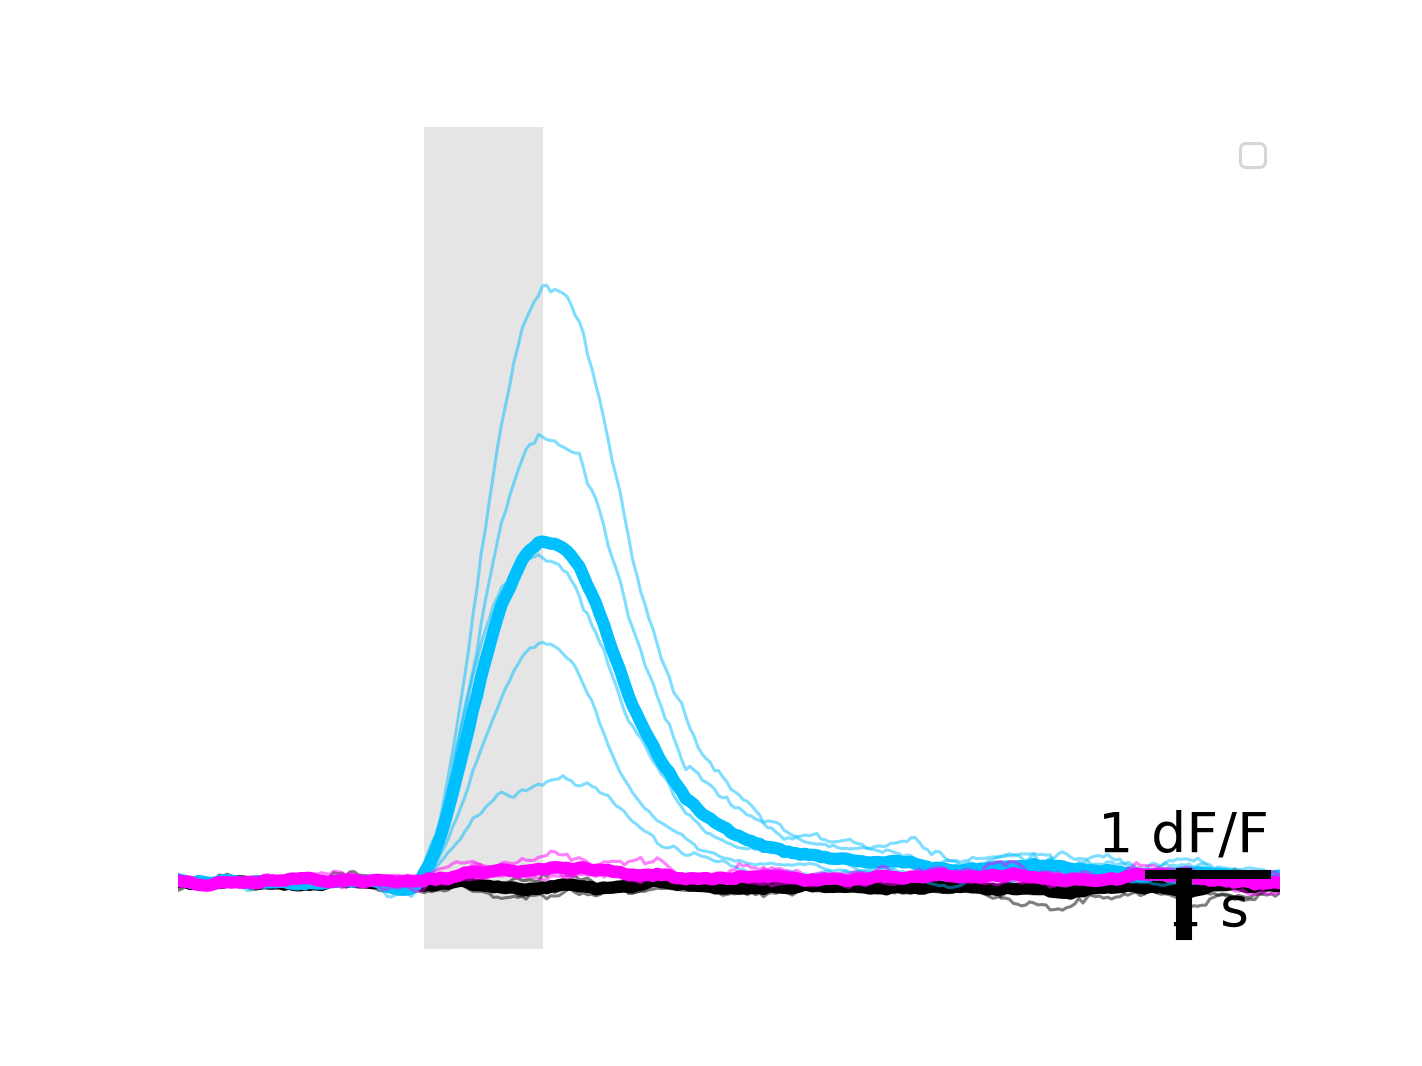

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [15]:
# Then, plot the trace plot
fig = plt.figure()
ax = fig.add_subplot(111)

# First, plot light intensity 8uW/mmw 
stim_intensity = 0

for group in range(3):
    ############ CONTINIUE HERE

    ax.plot(data[:,0,0,stim_intensity, group], median_per_animal[:,:,stim_intensity, group], 
            lw=1, zorder=1, color=colors[group], alpha=0.5)
    # and plot the mean of the median in bold
    ax.plot(data[:,0,0,stim_intensity, group], 
            np.mean(median_per_animal[:,:,stim_intensity, group], axis=1), 
            lw=4, zorder=1, color=colors[group])

# Plot stimulus
start_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][0]
stop_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][-1]
ax.axvspan(data[start_stim, 0, 0, stim_intensity, 0],
           data[stop_stim, 0, 0, stim_intensity, 0],
           lw=0, zorder=0,
           color='k',
           alpha=0.1)
ax.set_xlim(1, 10)

fontprops = fm.FontProperties(size=18)
scalebar_time = AnchoredSizeBar(ax.transData,
                                1, '1 s', 'lower right',
                                pad=0.1,
                                color='black',
                                frameon=False,
                                size_vertical=0.1,
                                fontproperties=fontprops)

scalebar_df = AnchoredSizeBar(ax.transData,
                              0.1, '1 dF/F', 'lower right',
                              pad=0.1,
                              color='black',
                              frameon=False,
                              size_vertical=1,
                              fontproperties=fontprops,
                              label_top=True)

ax.add_artist(scalebar_time)
ax.add_artist(scalebar_df)
ax.legend()
ax.axis('off')
ax.set_ylim(-1,11)

savename = 'Fig6D_8uW.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

<IPython.core.display.Javascript object>


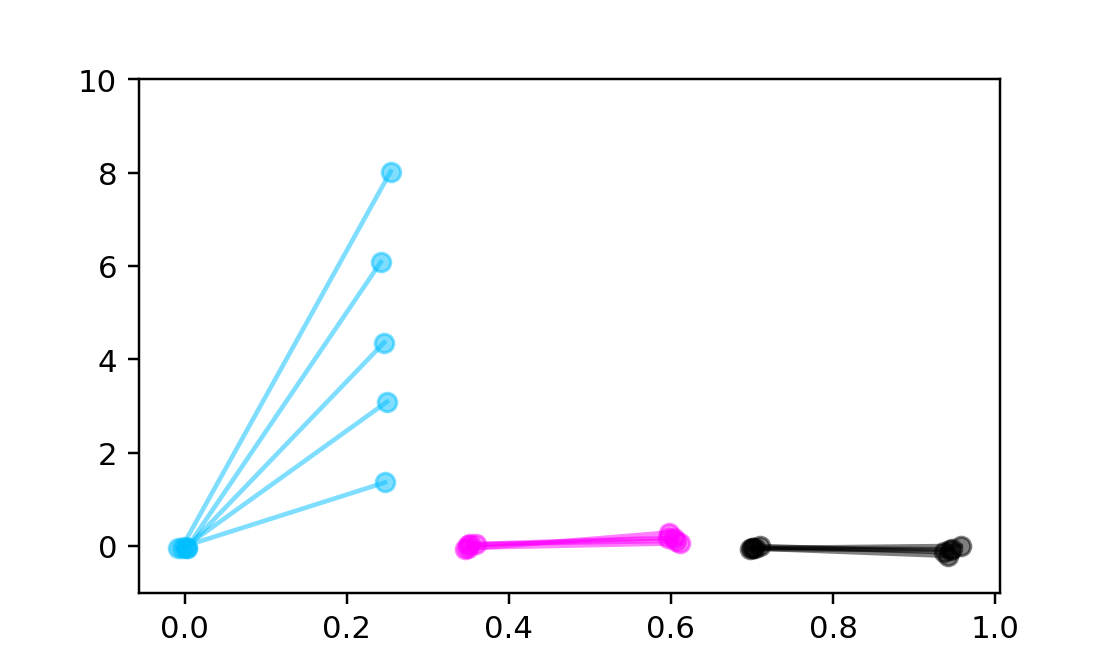

In [16]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)

stim_intensity = 0 # 8 uW/mm2
# First plot Gal4+, ATR+
shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[1], start_x_position=0, group=1)
# Then Gal4-, ATR+
shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[2], start_x_position=0.35, group=2)
# Finally Gal4+, ATR-
shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[0], start_x_position=0.7, group=0)

ax.set_ylim(-1,10)
savename = 'Fig6E_8uW.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

In [17]:
p_values=[]


stim_intensity = 0 # 8 uW/mm2

# median_before_stim_ATR.shape
# (5, 3, 3) # Animal, light intensity, group
print('Gal4+, ATR+')
shared_func.pairwise_t_tests(median_during_stim[:,stim_intensity,1], 
                             median_before_stim[:,stim_intensity,1], p_values) # Gal4+, ATR+
print('Gal4-, ATR+')
shared_func.pairwise_t_tests(median_during_stim[:,stim_intensity,2], 
                             median_before_stim[:,stim_intensity,2], p_values) # Gal4-, ATR+
print('Gal4+, ATR-')
shared_func.pairwise_t_tests(median_during_stim[:,stim_intensity,0], 
                             median_before_stim[:,stim_intensity,0], p_values) # Gal4+, ATR-


print('Holms-Bonferroni correction:')
shared_func.holms_bonferroni_correction(p_values)

Gal4+, ATR+
lilliefors: 0.99
T-Test
TtestResult(statistic=3.994461979781473, pvalue=0.016204596414033746, df=4)


Gal4-, ATR+
lilliefors: 0.07067840797061674
T-Test
TtestResult(statistic=3.2316266905547035, pvalue=0.03192625311694849, df=4)


Gal4+, ATR-
lilliefors: 0.5594742502975039
T-Test
TtestResult(statistic=-1.7117382131208283, pvalue=0.16211042223919658, df=4)


Holms-Bonferroni correction:
significantly different with:
current p: 0.016204596414033746, current alpha: 0.016666666666666666
NOT DIFFERENT!
current p: 0.03192625311694849, current alpha: 0.025
NOT DIFFERENT!
current p: 0.16211042223919658, current alpha: 0.05


In [18]:
stim_intensity = 0 # 8 uW/mm2

data_export = [[median_during_stim[:,stim_intensity,1], median_before_stim[:,stim_intensity,1]],
               [median_during_stim[:,stim_intensity,2], median_before_stim[:,stim_intensity,2]],
               [median_during_stim[:,stim_intensity,0], median_before_stim[:,stim_intensity,0]]
       ]

label_list_stat_export = [['During, Gal4+, ATR+', 'Before, Gal4+, ATR+'],
                          ['During, Gal4-, ATR+', 'Before, Gal4-, ATR+'],
                          ['During, Gal4+, ATR-', 'Before, Gal4+, ATR-']]
savename = 'Fig_6E_8uW'

shared_func.export_pairwise_dependent_test(data_export, label_list_stat_export,
                                           savepath=stat_savepath, savename=savename,
                                           parametric=True)

                 Group  n      mean    median       STD       SEM  \
0  During, Gal4+, ATR+  5  4.583826  4.360100  2.313281  1.034531   
1  Before, Gal4+, ATR+  5 -0.040571 -0.042398  0.011089  0.004959   
2  During, Gal4-, ATR+  5  0.160820  0.167290  0.077281  0.034561   
3  Before, Gal4-, ATR+  5 -0.002505  0.012965  0.043007  0.019233   
4  During, Gal4+, ATR-  5 -0.101729 -0.094623  0.070084  0.031342   
5  Before, Gal4+, ATR-  5 -0.038402 -0.044272  0.021477  0.009605   

                              95% CI on the mean  DOF statistical test  \
0        (1.3724776757432595, 7.795174135359125)  4.0       T-test rel   
1   (-0.05596445043223865, -0.02517672441400108)  NaN              NaN   
2     (0.053536918786329005, 0.2681040374046699)  4.0       T-test rel   
3     (-0.06220892703453653, 0.0571984104877438)  NaN              NaN   
4  (-0.19902017729166033, -0.004436982212501481)  4.0       T-test rel   
5   (-0.0682174283668438, -0.008586845436615677)  NaN              NaN  